# Common Neighbor Rule in PyC Subgraph (Full)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.visualization import *
from utils.common_neighbor_rule import *

### 1. Create PyC Subgraph

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [6]:
g_full = get_thresholded_graph(g_actual, axls, -1)
print(nx.info(g_full))

Name: 
Type: DiGraph
Number of nodes: 363
Number of edges: 1750
Average in degree:   4.8209
Average out degree:   4.8209


### 2. Common Neighbor Rule (OBS vs ER vs CFG)

In [7]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_full)

CPU times: user 640 ms, sys: 0 ns, total: 640 ms
Wall time: 1.91 s


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [8]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,44285.0,62906.0,50026.0,465.0,1290.0,973.0,1280.0,955.0,10.0,18.0,0.010500,0.020507,0.019450
1,13395.0,1445.0,12213.0,436.0,163.0,527.0,155.0,517.0,8.0,10.0,0.032549,0.112803,0.043151
2,4545.0,723.0,2698.0,312.0,118.0,155.0,110.0,153.0,8.0,2.0,0.068647,0.163209,0.057450
3,1804.0,320.0,622.0,181.0,69.0,49.0,64.0,48.0,5.0,1.0,0.100333,0.215625,0.078778
4,802.0,144.0,117.0,132.0,26.0,11.0,26.0,11.0,0.0,0.0,0.164589,0.180556,0.094017
5,404.0,68.0,22.0,74.0,13.0,4.0,13.0,4.0,0.0,0.0,0.183168,0.191176,0.181818
6,182.0,39.0,5.0,37.0,18.0,0.0,18.0,0.0,0.0,0.0,0.203297,0.461538,0.000000
7,119.0,25.0,0.0,18.0,8.0,0.0,8.0,0.0,0.0,0.0,0.151261,0.320000,0.000000
8,63.0,14.0,0.0,22.0,7.0,0.0,7.0,0.0,0.0,0.0,0.349206,0.500000,0.000000
9,104.0,19.0,0.0,42.0,7.0,0.0,7.0,0.0,0.0,0.0,0.403846,0.368421,0.000000


In [9]:
%%time
# sample graphs from CFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples = continuous_sample_cnr(g_full, samples=s, niters=int(1e4))
cfg_cnr_stats, cfg_cnr_stats_std = cnr_mean_std(cfg_cnr_samples)


CPU times: user 3min 22s, sys: 132 ms, total: 3min 22s
Wall time: 3min 22s


In [11]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats.to_csv("saved/full_cnr_cfg100.csv", index=False)
cfg_cnr_stats_std.to_csv("saved/full_cnrstd_cfg100.csv", index=False)

In [12]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats = pd.read_csv("saved/full_cnr_cfg100.csv")
cfg_cnr_stats_std = pd.read_csv("saved/full_cnrstd_cfg100.csv")

In [13]:
cfg_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,34168.99,53105.78,40098.92,510.41,1307.66,1040.92,1301.62,1028.61,6.04,12.31,0.014938,0.024624,0.025959
1,13650.00,1480.28,12421.74,449.57,181.62,490.74,175.43,483.26,6.19,7.48,0.032936,0.122725,0.039507
2,4641.75,717.05,2718.26,302.90,108.32,149.98,104.33,147.58,3.99,2.40,0.065250,0.151064,0.055167
3,1834.82,331.79,567.63,188.23,57.58,36.35,54.93,35.87,2.65,0.48,0.102577,0.173499,0.064043
4,818.55,153.33,112.34,113.30,32.02,7.55,30.55,7.43,1.47,0.12,0.138431,0.208846,0.066536
5,395.00,73.16,21.44,66.38,16.96,1.42,15.98,1.42,0.98,0.00,0.167986,0.231812,0.064754
6,199.89,36.87,3.89,39.18,9.33,0.19,8.83,0.19,0.50,0.00,0.195987,0.252444,0.043218
7,103.34,20.01,0.66,22.57,5.56,0.05,5.21,0.05,0.35,0.00,0.217712,0.276871,0.033333
8,57.01,11.10,0.12,13.71,3.07,0.01,2.87,0.01,0.20,0.00,0.239306,0.274868,0.005000
9,75.65,15.63,0.00,20.96,5.09,0.00,4.67,0.00,0.42,0.00,0.274827,0.330607,0.000000


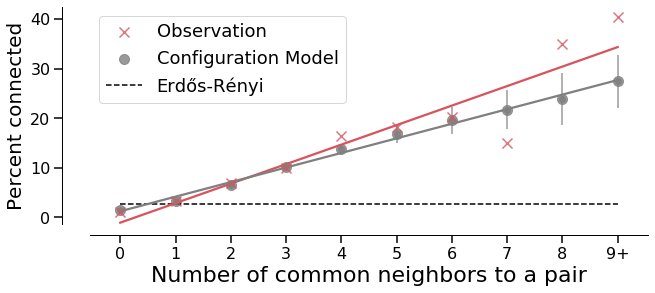

In [14]:
# plot CNR curves
E, N = len(g_full.edges), len(g_full.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null, figsize=(10,4), fname="full/full_cnr")

In [15]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8654259685162915, 9.495865324184074e-05)

In [16]:
# Pearson r^2 and p-value for CFG
pearson_r2(np.arange(10), cfg_cnr_stats["undir_perc"])

(0.9945213430805371, 2.4689281928199044e-10)

### 3. Common Neighbor Rule (OBS vs gER vs gCFG)

In [17]:
%%time
# sample graphs from gCFG model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
cfg_cnr_samples_GE = continuous_sample_cnr_GE(g_full, samples=s, niters=int(1e4))
cfg_cnr_stats_GE, cfg_cnr_stats_std_GE = cnr_mean_std(cfg_cnr_samples_GE)


CPU times: user 3min 43s, sys: 80 ms, total: 3min 43s
Wall time: 3min 44s


In [18]:
# save sampled CNR stats from CFG model as intermediate data
cfg_cnr_stats_GE.to_csv("saved/full_cnr_gcfg100.csv", index=False)
cfg_cnr_stats_std_GE.to_csv("saved/full_cnrstd_gcfg100.csv", index=False)

In [19]:
# load precomputed CNR stats counts from CFG model
cfg_cnr_stats_GE = pd.read_csv("saved/full_cnr_gcfg100.csv")
cfg_cnr_stats_std_GE = pd.read_csv("saved/full_cnrstd_gcfg100.csv")

In [20]:
cfg_cnr_stats_GE

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,34323.94,53125.74,40274.34,517.68,1307.86,1050.85,1300.02,1033.90,7.84,16.95,0.015083,0.024618,0.026093
1,13612.23,1473.91,12310.41,451.35,180.06,482.63,171.97,472.54,8.09,10.09,0.033157,0.122155,0.039209
2,4607.27,713.07,2671.86,302.54,104.47,142.32,98.58,139.20,5.89,3.12,0.065665,0.146541,0.053265
3,1809.09,327.44,552.82,184.94,57.93,34.58,54.30,33.90,3.63,0.68,0.102265,0.176856,0.062545
4,798.83,150.93,110.25,109.35,29.81,7.07,27.57,6.94,2.24,0.13,0.136941,0.197223,0.064327
5,379.09,71.92,20.70,62.25,16.32,1.33,15.16,1.32,1.16,0.01,0.164170,0.226404,0.062714
6,190.55,36.18,3.87,36.99,9.08,0.21,8.24,0.19,0.84,0.02,0.194052,0.251327,0.059254
7,98.75,19.29,0.63,21.12,5.09,0.01,4.62,0.01,0.47,0.00,0.214151,0.264656,0.005000
8,53.80,11.17,0.12,13.08,3.28,0.00,3.00,0.00,0.28,0.00,0.242553,0.299216,0.000000
9,71.45,15.35,0.00,19.70,5.10,0.00,4.54,0.00,0.56,0.00,0.275281,0.330084,0.000000


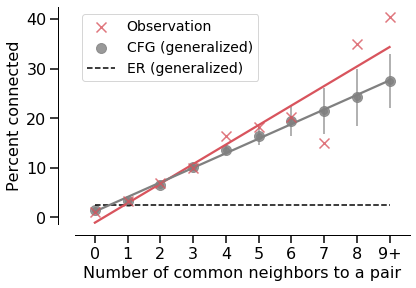

In [21]:
# plot CNR curves
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_full)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, cfg_cnr_stats_GE, cfg_cnr_stats_std_GE, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), cfg_name="CFG (generalized)", er_name="ER (generalized)", fname="full/full_cnr_GE")

In [22]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8654259685162915, 9.495865324184074e-05)

In [23]:
# Pearson r^2 and p-value for gCFG
pearson_r2(np.arange(10), cfg_cnr_stats_GE["undir_perc"])

(0.9964073937992797, 4.561646108739011e-11)

### 4. Common Neighbor Rule (OBS vs gER vs CFG)

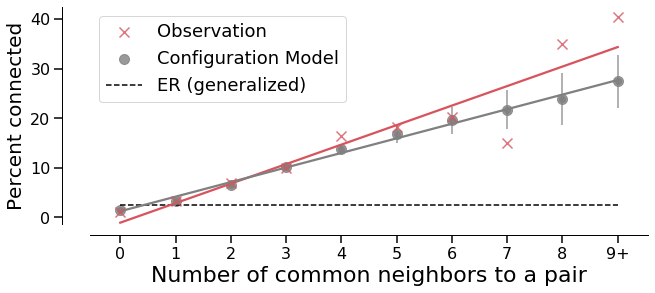

In [24]:
# plot CNR curves
plot_cnr(obs_cnr_stats, cfg_cnr_stats, cfg_cnr_stats_std, ER_p_null_GE, figsize=(10,4), 
         er_name="ER (generalized)", fname="full/full_cnr_CGE")